# **1. 주제소개**

> <font size = 5>선정기준</font>
- 최근 많은 사람들이 관심 갖는 주제 선정
- 수요예측 분석
<hr>

> <font size = 5>주제선정</font>
- "Food Demanding Forecasting" 데이터셋 분석
<hr>

> <font size = 5>선정이유</font>
- 최근 코로나 사태 이후, 배달 음식에 대한 사람들의 수요가 높아짐
- 단순한 완제품 배달 뿐만 아니라, 식재료 배달에 대한 수요도 크게 증가함
>> *많은 사람들이 관심 가질 만한 주제*

- 폐기율과 품절율의 딜레마로 정확한 수요예측을 기반으로 재고 확보가 필요
- 또한 분류 작업 및 배송 등에 필요한 인력을 수요예측을 기반으로 배치 필요
>> *정확한 수요예측의 필요성 및 중요성의 증가*





# **2. 분석 계획**

- 1) 데이터 수집 
- 2) 데이터 탐구 및 이용 준비
- 3) 데이터 시각화 및 특성 분석
- 4) Feature Engineering
- 5) 머신러닝 모델 탐색 및 학습시키기
- 6) 최적 머신러닝 모델 선정

# **3. 분석 결과 리뷰**

## 1) 데이터 수집

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings('ignore')

## 2) 데이터 탐구 및 이용 준비

### Data Information

####train & test
- id : Unique ID
- week : Week No
- center_id : Unique ID for fulfillment center
- meal_id : Unique ID for Meal
- checkout_price : Final price including discount, taxes & delivery charges
- base_price : Base price of the meal
- emailer_for_promotion : Emailer sent for promotion of meal
- homepage_featured : Meal featured at homepage
- num_orders : (Target) Orders Count

####fulfilment_center_info
- center_id : Unique ID for fulfilment center
- city_code : Unique code for city
- region_code : Unique code for region
- center_type : Anonymized center type
- op_area : Area of operation (in km^2) - 각 center가 담당하는 지역의 넓이

####meal_info
- meal_id : Unique ID for the meal
- category : Type of meal(beverages/snacks/soups...)
- cuisine : Meal cuisine(Indian/Italian...)


### Preparing Dataset

In [3]:
train = pd.read_csv('/gdrive/My Drive/전산통계/kaggle/train.csv')
test = pd.read_csv('/gdrive/My Drive/전산통계/kaggle/test.csv')
center = pd.read_csv('/gdrive/My Drive/전산통계/kaggle/fulfilment_center_info.csv')
meal = pd.read_csv('/gdrive/My Drive/전산통계/kaggle/meal_info.csv')

In [4]:
print("shape of Train dataset :", train.shape)
print("shape of Test dataset :", test.shape)
print("shape of Fulfilment_center_info  dataset :", center.shape)
print("shape of Meal_info dataset :", meal.shape)

shape of Train dataset : (456548, 9)
shape of Test dataset : (32573, 8)
shape of Fulfilment_center_info  dataset : (77, 5)
shape of Meal_info dataset : (51, 3)


In [5]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [6]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [7]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [8]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


<font color=red>train 데이터는 145주동안 77개의 지점에서 51개의 품목을 각각 얼만큼씩 팔았는지에 대한 데이터다! (주별로 지점마다 판매되지 않은 품목들도 존재함)</font>

### Data Preprocessing

#### 데이터 병합

In [9]:
# train 데이터와 합쳐 추가될 feature들 넣어주기 위해 columns 맞춰주는 것!
test['num_orders'] = 123456

In [10]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,123456
1,1127204,146,55,1993,160.11,159.11,0,0,123456
2,1212707,146,55,2539,157.14,159.14,0,0,123456
3,1082698,146,55,2631,162.02,162.02,0,0,123456
4,1400926,146,55,1248,163.93,163.93,0,0,123456


In [11]:
data = pd.concat([train, test], axis=0)

In [12]:
# center 데이터 합치기
data = data.merge(center, on='center_id', how='left')

In [13]:
# meal 데이터 합치기
data = data.merge(meal, on='meal_id', how='left')

In [14]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


#### null값 유무 확인하기

In [15]:
data.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

#### 데이터 정보 확인하기

In [16]:
data.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.891210e+05,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000
mean,1.249988e+06,79.810613,82.092206,2024.852268,332.879277,354.312259,0.080172,0.107346,8465.982391,601.551172,56.621065,4.083865
std,1.443421e+05,44.343325,45.973390,547.408978,153.022073,160.352168,0.271560,0.309552,30717.079213,66.182598,17.641296,1.092163
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,13.000000,456.000000,23.000000,0.900000
25%,1.124937e+06,42.000000,43.000000,1558.000000,228.010000,243.500000,0.000000,0.000000,55.000000,553.000000,34.000000,3.600000
50%,1.249977e+06,81.000000,76.000000,1993.000000,299.760000,311.430000,0.000000,0.000000,161.000000,596.000000,56.000000,4.000000
75%,1.374988e+06,118.000000,110.000000,2539.000000,445.230000,458.810000,0.000000,0.000000,392.000000,651.000000,77.000000,4.500000
max,1.499999e+06,155.000000,186.000000,2956.000000,1113.620000,1112.620000,1.000000,1.000000,123456.000000,713.000000,93.000000,7.000000


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 489120
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             489121 non-null  int64  
 9   city_code              489121 non-null  int64  
 10  region_code            489121 non-null  int64  
 11  center_type            489121 non-null  object 
 12  op_area                489121 non-null  float64
 13  category               489121 non-null  object 
 14  cuisine                489121 non-nu

In [18]:
data.apply(lambda x: len(x.unique()))

id                       489121
week                        155
center_id                    77
meal_id                      51
checkout_price             1995
base_price                 1931
emailer_for_promotion         2
homepage_featured             2
num_orders                 1251
city_code                    51
region_code                   8
center_type                   3
op_area                      30
category                     14
cuisine                       4
dtype: int64

#### train test Split

In [19]:
train = data[data['week'].isin(range(1,146))]
test = data[data['week'].isin(range(146,156))]

In [20]:
print('shape of train dataset :', train.shape)
print('shape of test dataset :', test.shape)

shape of train dataset : (456548, 15)
shape of test dataset : (32573, 15)


## 3) 데이터 시각화 및 특성 분석

### Data Visualization

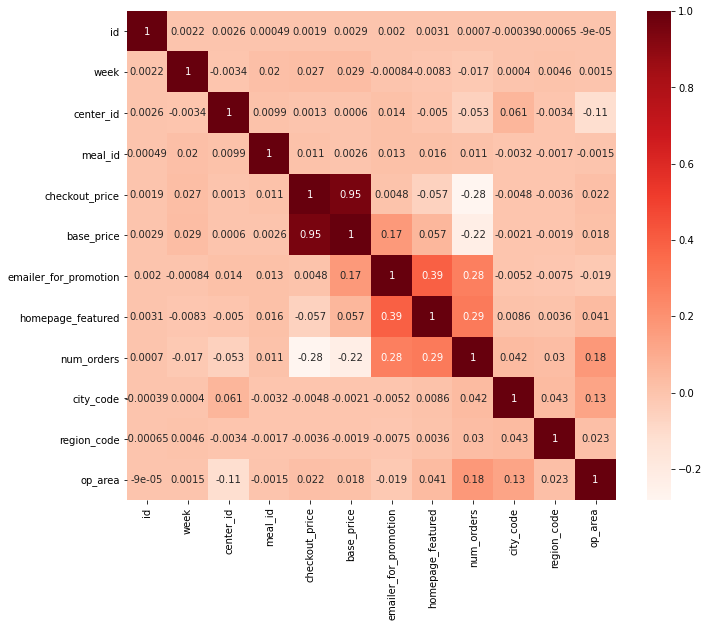

In [21]:
# 각 feature별 상관관계
plt.figure(figsize=(11,9))
sns.heatmap(train.corr(), annot=True, square=True, cmap='Reds')

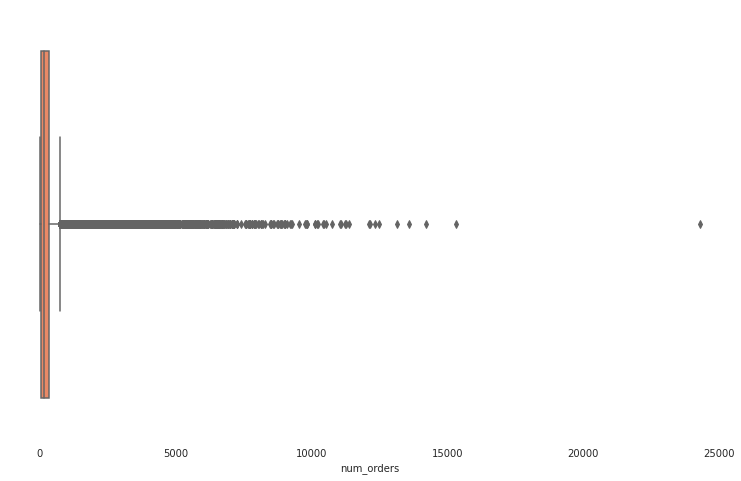

In [22]:
# 주문량의 boxplot
sns.set_style('white')
plt.figure(figsize=(13,8))
sns.boxplot(train['num_orders'], color='coral')
sns.despine(bottom=True, left=True)

- <font color=red>outlier가 꽤 존재함을 확인할 수 있음</font>
- <font color=red>모델에 넣기 전에 이에 대한 feature engineering이 필요하다고 판단됨</font>

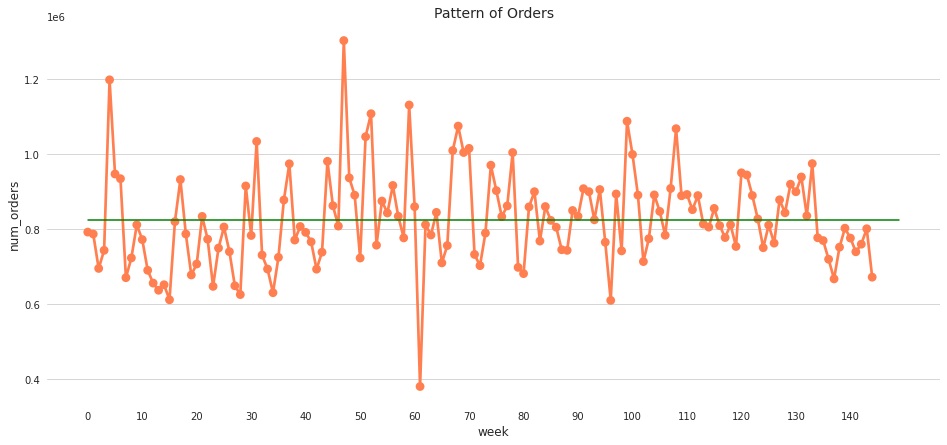

In [23]:
# 주별 주문량 패턴
fig=plt.figure(figsize=(16,7))
sns.set_style('whitegrid')
plt.title('Pattern of Orders', fontdict={'fontsize':14})

sns.pointplot(x=train.groupby('week').sum().reset_index()['week'],
              y=train.groupby('week').sum().reset_index()['num_orders'],
              color='coral'
              );
plt.xticks(range(0, 150, 10), list(np.arange(0, 160, 10)))
plt.ylabel('num_orders', fontdict={'fontsize':12})
plt.xlabel('week', fontdict={'fontsize':12})
plt.plot(range(0,150), [train.groupby('week').sum().reset_index()['num_orders'].mean()]*150, color='green') # 주별 주문량 평균선 넣기
sns.despine(bottom=True, left=True)

- <font color=red>주별 주문량을 보면, 48번째 주가 가장 주문량이 높았고, 62번째 주가 가장 주문량이 낮았음</font>
- <font color=red>전반적으로 주별 주문량의 평균을 중심으로 움직이는 모습을 보임</font>


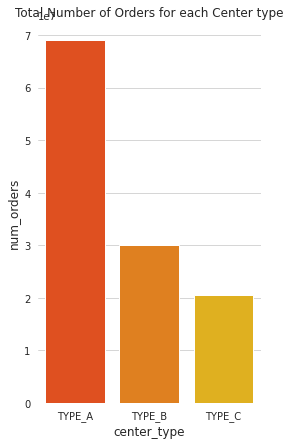

In [25]:
# center_type별 주문량
fig = plt.figure(figsize=(4,7))
plt.title("Total Number of Orders for each Center type")
sns.barplot(y='num_orders', x='center_type', data=train.groupby('center_type').sum()['num_orders'].reset_index(), palette='autumn');
plt.ylabel('num_orders', fontdict={'fontsize':12})
plt.xlabel('center_type', fontdict={'fontsize':12})
sns.despine(bottom=True, left=True)

- <font color='red'>TYPE_A가 가장 많은 주문량을 가짐</font>
- <font color='red'>TYPE_C가 가장 적은 주문량을 가짐</font>

In [24]:
# center의 수
train['center_id'].nunique()

77

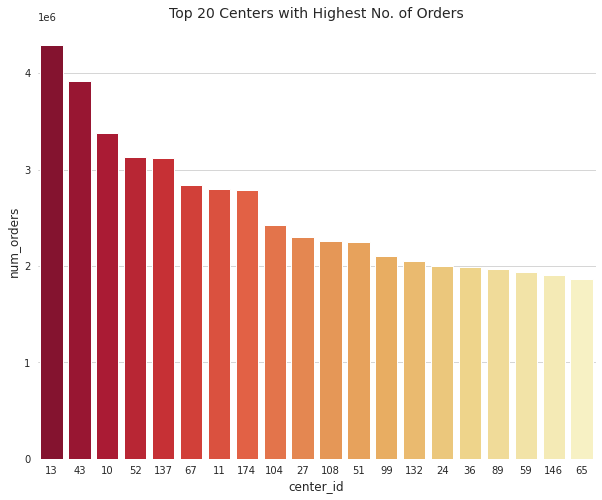

In [26]:
# center별 주문량 상위 20곳
fig = plt.figure(figsize=(10,8))
plt.title('Top 20 Centers with Highest No. of Orders', fontdict={'fontsize':14})
sns.barplot(y='num_orders', 
            x='center_id', 
            data=train.groupby(['center_id']).num_orders.sum().sort_values(ascending=False).reset_index().head(20), 
            palette='YlOrRd_r', 
            order=list(train.groupby(['center_id']).num_orders.sum().sort_values(ascending=False).reset_index().head(20)['center_id'])
            );
plt.ylabel('num_orders', fontdict={'fontsize':12})
plt.xlabel('center_id', fontdict={'fontsize':12})
sns.despine(bottom=True, left=True)

In [27]:
# 주문량이 가장 많은 center의 center_type
train[train['center_id'] == 13]['center_type'].unique()

array(['TYPE_B'], dtype=object)

In [28]:
# 상위 20곳이 속한 center_type
id_to_type = list(train.groupby(['center_id']).num_orders.sum().sort_values(ascending=False).reset_index().head(20)['center_id'])
type_dic = dict()
for val in id_to_type:
    _tmp = train[train['center_id'] == val]['center_type'].unique()[0]
    if _tmp in type_dic.keys():
        type_dic[_tmp] += 1
    else:
        type_dic[_tmp] = 1
        
for key, value in type_dic.items():
    print("상위 20 곳의 center 중 %s은 %d개 있습니다" %(key, value))

상위 20 곳의 center 중 TYPE_B은 8개 있습니다
상위 20 곳의 center 중 TYPE_A은 12개 있습니다


- <font color=red>TYPE_A의 주문량이 TYPE_B에 비해 2배 이상 많지만, 반대로 가장 주문량이 많은 center13은 TYPE_B에 속함</font>

- <font color=red>또한 상위 20곳의 center 중 TYPE_B에 속해있는 곳이 8개나 됨</font>

- <font color=red>TYPE_A의 주문량이 많은 것은 단순히 TYPE_A에 속해있는 center가 많아서 발생한 현상일지도 모르고, 이에 대한 분석 필요</font>

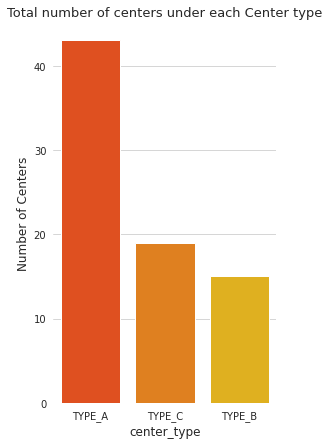

In [29]:
# center_type별 center의 수
fig=plt.figure(figsize=(4,7))
plt.title('Total number of centers under each Center type', fontdict={'fontsize':13})
sns.barplot(y=train.groupby(['center_id', 'center_type']).num_orders.sum().reset_index()['center_type'].value_counts(),
            x=train.groupby(['center_id', 'center_type']).num_orders.sum().reset_index()['center_type'].value_counts().index,
            palette='autumn'
            );
plt.ylabel('Number of Centers', fontdict={'fontsize':12})
plt.xlabel('center_type', fontdict={'fontsize':12})
sns.despine(bottom=True, left=True)

- <font color=red>확인 결과, TYPE_A의 주문량이 월등히 많은 것은 그만큼 많은 center를 가져서 발생한 것으로 보임</font>

In [30]:
# city의 수
train['city_code'].nunique()

51

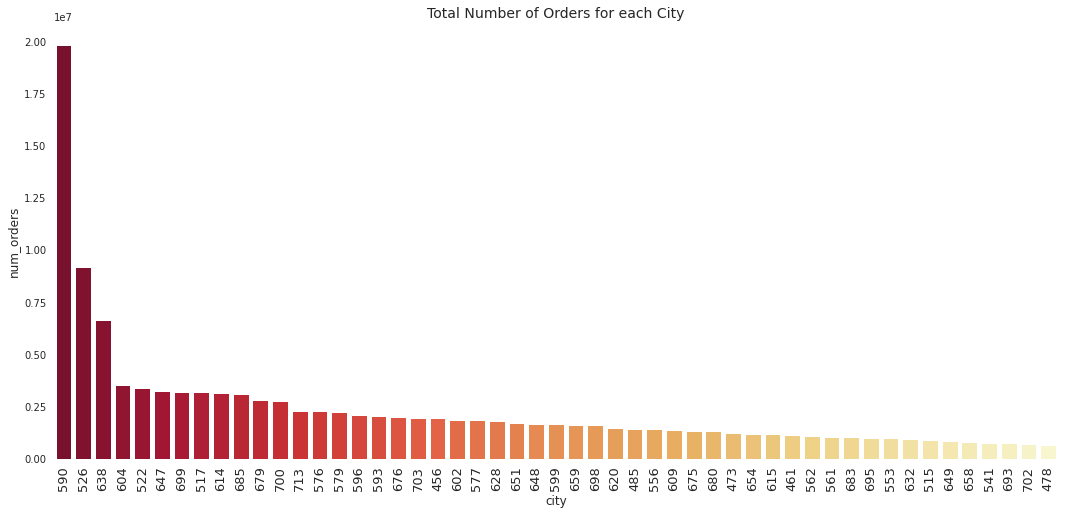

In [31]:
# city별 주문량
fig=plt.figure(figsize=(18,8))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=13)
plt.title('Total Number of Orders for each City',fontdict={'fontsize':14})
sns.barplot(y='num_orders', 
            x='city_code', 
            data=train.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index(),
            palette='YlOrRd_r',
            order=list(train.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index()['city_code'].values));
plt.ylabel('num_orders',fontdict={'fontsize':12})
plt.xlabel('city',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True)

In [32]:
city_orders = list(train.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index().values[:,0])

# 가장 주문량이 많은 56번 region의 주문량이 전체에서 차지하는 비율
print("590번 city의 주문량은 전체의 %0.2f%% 입니다." % (train[train['city_code'] == 590]['num_orders'].sum() / train['num_orders'].sum() * 100))

# 가장 주문량이 많은 상위 3곳의 region의 주문량이 전체에서 차지하는 비율
cnt = 0
for i in range(3):
    cnt += train[train['city_code'] == city_orders[i]]['num_orders'].sum()
print("상위 3곳 city의 주문량은 전체의 %0.2f%% 입니다." % (cnt / train['num_orders'].sum()* 100))

590번 city의 주문량은 전체의 16.60% 입니다.
상위 3곳 city의 주문량은 전체의 29.88% 입니다.


- <font color='red'>전체 51곳의 city 중 590번 city가 전체 주문량의 약 17%를 차지하고, 상위 3곳이 약 30%를 차지함</font>
- <font color='red'>즉, city별 주문량이 특정 지역에서 유독 높게 나타남을 알 수 있음</font>

In [33]:
# region의 수
train['region_code'].nunique()

8

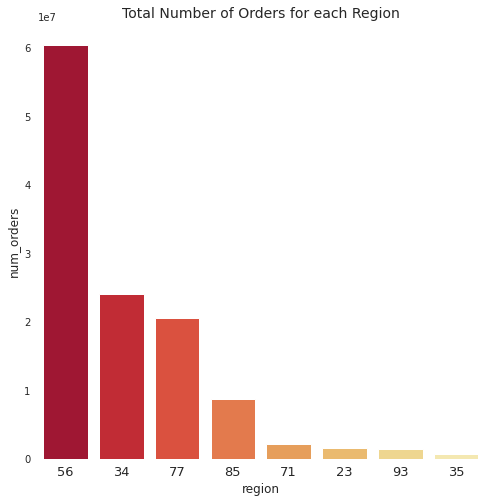

In [34]:
# region별 주문량
fig=plt.figure(figsize=(8,8))
sns.set_style("white")
plt.xticks(fontsize=13)
plt.title('Total Number of Orders for each Region',fontdict={'fontsize':14})
sns.barplot(y='num_orders', 
            x='region_code',
            data=train.groupby('region_code').num_orders.sum().sort_values(ascending=False).reset_index(),
            palette='YlOrRd_r',
            order=list(train.groupby('region_code').num_orders.sum().sort_values(ascending=False).reset_index().values[:,0]));
plt.ylabel('num_orders',fontdict={'fontsize':12})
plt.xlabel('region',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True)

In [35]:
region_orders = list(train.groupby('region_code').num_orders.sum().sort_values(ascending=False).reset_index().values[:,0])

# 가장 주문량이 많은 56번 region의 주문량이 전체에서 차지하는 비율
print("56번 region의 주문량은 전체의 %0.2f%% 입니다." % (train[train['region_code'] == 56]['num_orders'].sum() / train['num_orders'].sum() * 100))

# 가장 주문량이 많은 상위 3곳의 region의 주문량이 전체에서 차지하는 비율
cnt = 0
for i in range(3):
    cnt += train[train['region_code'] == region_orders[i]]['num_orders'].sum()
print("상위 3곳 region의 주문량은 전체의 %0.2f%% 입니다." % (cnt / train['num_orders'].sum()* 100))

56번 region의 주문량은 전체의 50.62% 입니다.
상위 3곳 region의 주문량은 전체의 87.91% 입니다.


- <font color=red>주문량이 가장 많은 region이 주문량 전체의 절반 정도를 차지하고, 상위 3곳이 주문량 전체의 약 90%를 차지함</font>
- <font color=red>city와 마찬가지로 주문량이 특정 region에서 유독 높게 나타남을 알 수 있고, 특히 city보다 더 크게 특정 지역으로 주문량이 편향되어 있음</font>

In [36]:
# op_area의 수
train['op_area'].nunique()

30

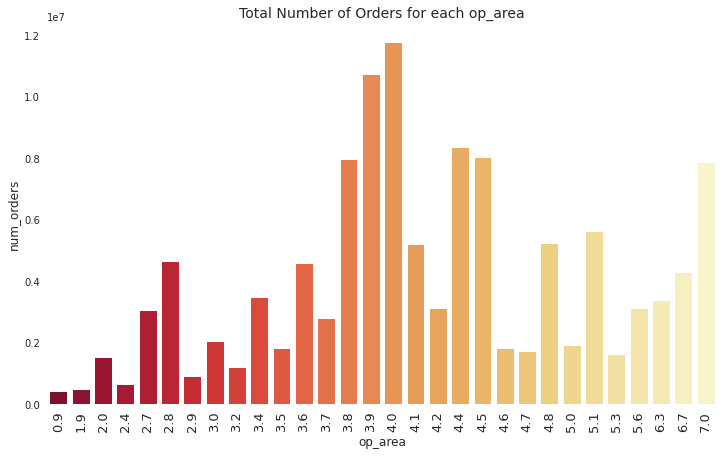

In [37]:
#op_area별 주문량
fig=plt.figure(figsize=(12,7))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=13)
plt.title('Total Number of Orders for each op_area',fontdict={'fontsize':14})
sns.barplot(y='num_orders', 
            x='op_area', 
            data=train.groupby('op_area').num_orders.sum().reset_index(),
            palette='YlOrRd_r',
            order=list(train.groupby('op_area').num_orders.sum().reset_index()['op_area'].values));
plt.ylabel('num_orders',fontdict={'fontsize':12})
plt.xlabel('op_area',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True)

- <font color='red'>op_area가 (3.6 ~ 4.5) 정도일 때 주문량이 꽤 높게 나타남</font>
- <font color='red'>그러나 이는 각 op_area에 해당하는 center의 숫자 차이로 인한 현상일 수 있고, 이에 대한 분석 필요</font>

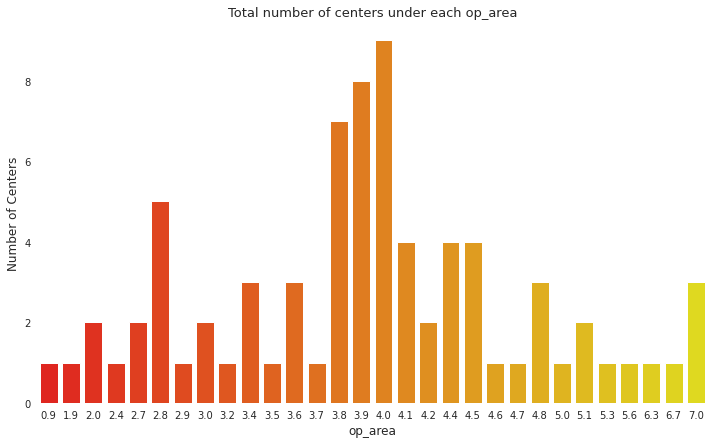

In [38]:
# op_area별 center의 수
fig=plt.figure(figsize=(12,7))
plt.title('Total number of centers under each op_area', fontdict={'fontsize':13})
sns.barplot(y=train.groupby(['center_id', 'op_area']).num_orders.sum().reset_index()['op_area'].value_counts(),
            x=train.groupby(['center_id', 'op_area']).num_orders.sum().reset_index()['op_area'].value_counts().index,
            palette='autumn'
            );
plt.ylabel('Number of Centers', fontdict={'fontsize':12})
plt.xlabel('op_area', fontdict={'fontsize':12})
sns.despine(bottom=True, left=True)

- <font color='red'>확인 결과, op_area에 따른 주문량은 각 op_area에 속한 center의 숫자와 관계가 있어보임</font> 
- <font color='red'>따라서 주문량이 op_area의 영향보다는 center 숫자의 영향을 받은 것으로 보임</font>

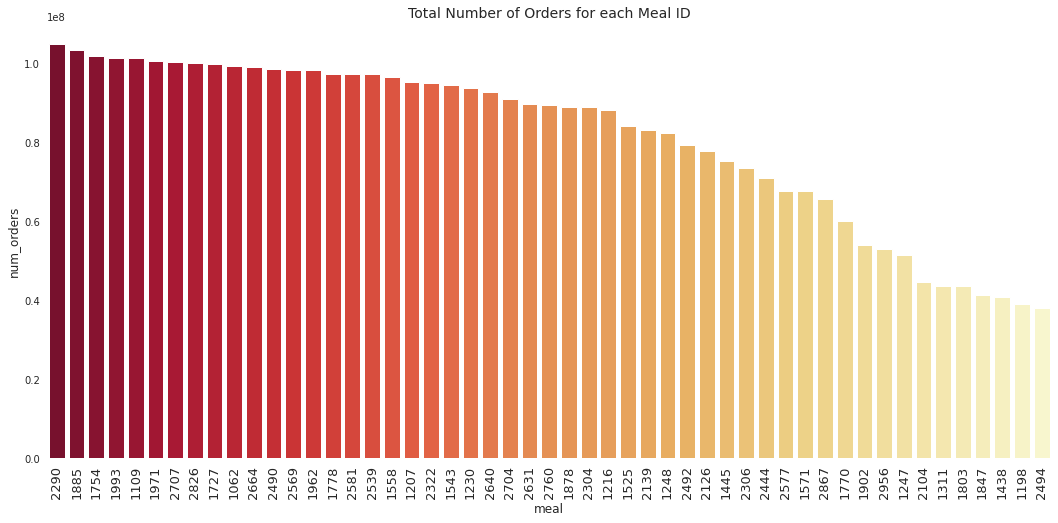

In [39]:
# meal_id별 주문량
fig=plt.figure(figsize=(18,8))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=13)
plt.title('Total Number of Orders for each Meal ID',fontdict={'fontsize':14})
sns.barplot(y='num_orders', 
            x='meal_id', 
            data=data.groupby('meal_id').num_orders.sum().sort_values(ascending=False).reset_index(),
            palette='YlOrRd_r',
            order=list(data.groupby('meal_id').num_orders.sum().sort_values(ascending=False).reset_index()['meal_id'].values));
plt.ylabel('num_orders',fontdict={'fontsize':12})
plt.xlabel('meal',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True)

- <font color='red'>meal_id가 2290인 품목이 가장 많은 주문량을 가짐</font>
- <font color='red'>그러나 meal_id별 주문량은 크게 중요한 차이를 보이지는 않음</font>

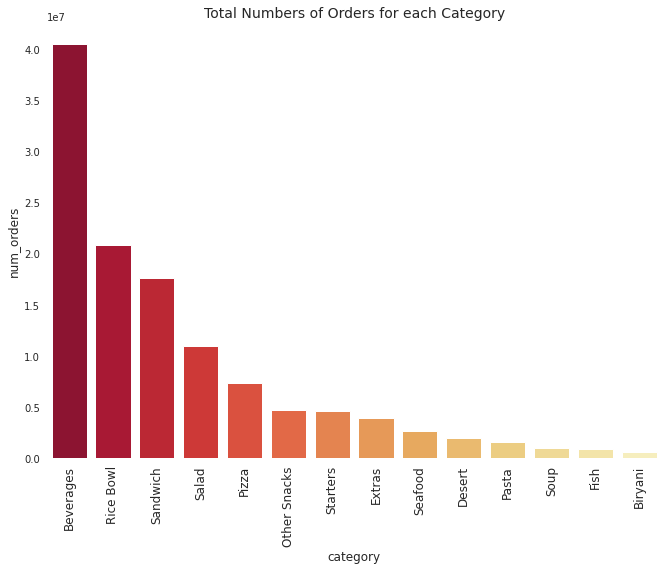

In [40]:
# category별 주문량
fig = plt.figure(figsize=(11,8))
sns.set_style('white')

plt.xticks(rotation=90, fontsize=12)
plt.title('Total Numbers of Orders for each Category', fontdict={'fontsize':14})
sns.barplot(y='num_orders',
            x='category',
            data=train.groupby('category').num_orders.sum().sort_values(ascending=False).reset_index(),
            palette='YlOrRd_r'
            );
plt.ylabel('num_orders', fontdict={'fontsize':12})
plt.xlabel('category', fontdict={'fontsize':12})
sns.despine(bottom=True, left=True)

- <font color='red'>category에서는 beverages가 가장 높은 주문량을 보이고, biryani가 가장 낮은 주문량을 보임</font>

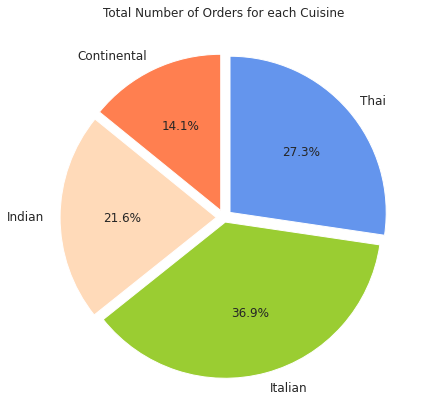

In [41]:
# cuisine별 주문량
plt.figure(figsize=(6,6))
colors = ['coral', '#FFDAB9', 'yellowgreen', '#6495ED']
plt.pie(train.groupby('cuisine').num_orders.sum(),
        labels=train.groupby('cuisine').num_orders.sum().index,
        shadow=False,
        colors=colors,
        explode=(0.05, 0.05, 0.03, 0.05),
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.6,
        textprops={'fontsize':12}
        )
plt.title('Total Number of Orders for each Cuisine')
plt.tight_layout()
plt.show()

- <font color='red'>주문량에서 Italian 음식이 가장 높은 점유율을 보이고, Continental 음식이 가장 낮은 점유율을 보임</font>

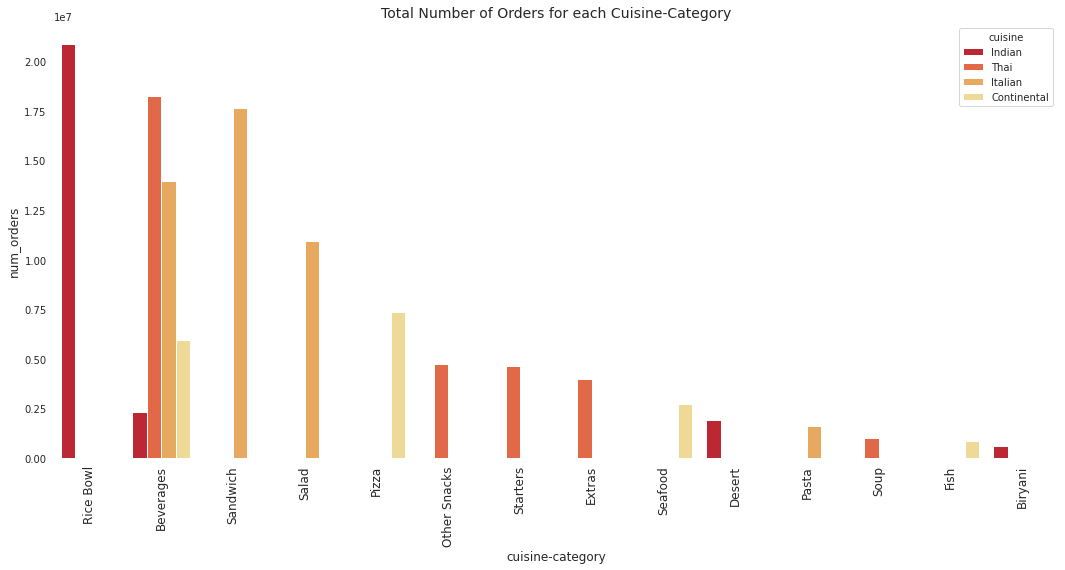

In [42]:
# cuisine-category별 주문량
fig=plt.figure(figsize=(18,8))
sns.set_style("white")
plt.xticks(rotation=90,fontsize=12)
plt.title('Total Number of Orders for each Cuisine-Category',fontdict={'fontsize':14})

sns.barplot(x='category',
            y='num_orders',
            data=train.groupby(['cuisine','category']).sum().sort_values(by='num_orders', ascending=False).reset_index(),
            hue='cuisine',
            palette='YlOrRd_r')

plt.ylabel('num_orders',fontdict={'fontsize':12})
plt.xlabel('cuisine-category',fontdict={'fontsize':12})
sns.despine(bottom = True, left = True);

- <font color='red'>Indian 음식인 rice bowl이 품목별 가장 높은 주문량을 보이지만, 다양한 국가의 beverages들에 대한 주문량이 고르게 많아 category 상에서 beverages의 주문량이 가장 높음</font>

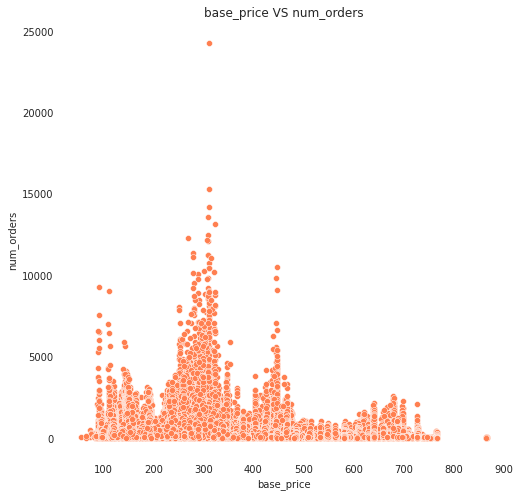

In [43]:
# base_price별 주문량
sns.set_style('white')
plt.figure(figsize=(8,8))
plt.title('base_price VS num_orders')
sns.scatterplot(y=train['num_orders'], x=train['base_price'], color='coral')
plt.ylabel('num_orders')
plt.xlabel('base_price')
sns.despine(bottom=True, left=True)

- <font color='red'>base_price와 주문량 간에 별다른 상관관계가 보이지는 않음</font>

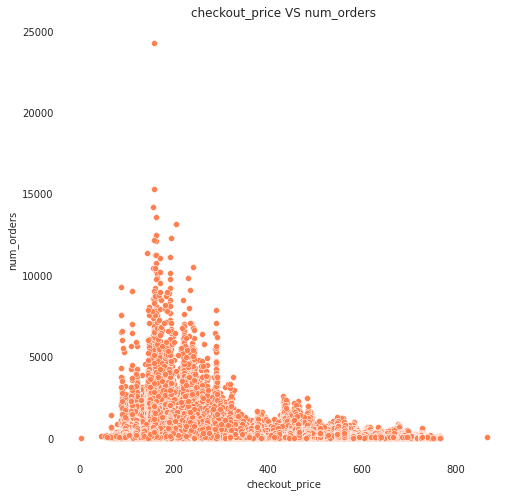

In [44]:
sns.set_style('white')
plt.figure(figsize=(8,8))
plt.title('checkout_price VS num_orders')
sns.scatterplot(y=train['num_orders'], x=train['checkout_price'], color='coral')
plt.ylabel('num_orders')
plt.xlabel('checkout_price')
sns.despine(bottom=True, left=True)

- <font color='red'>checkout_price와 주문량 간에 별다른 상관관계가 보이지는 않음</font>

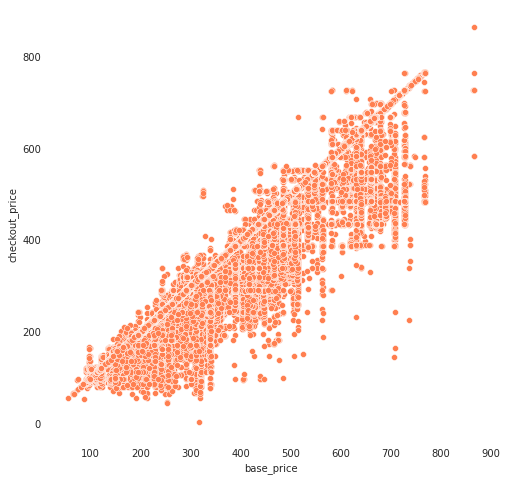

In [45]:
# base_price와 checkout_price 간의 scatter
sns.set_style('white')
plt.figure(figsize=(8,8))
sns.scatterplot(y=train['checkout_price'], x=train['base_price'], color='coral')
plt.ylabel('checkout_price')
plt.xlabel('base_price')
sns.despine(bottom=True, left=True)

- <font color='red'>대부분의 주문들이 원가보다 더 저렴한 가격에 판매되었음을 알 수 있음</font>
- <font color='red'>따라서 할인과 관련된 변수를 추가하면 더 좋을 것 같음</font>

## 4) Feature Engineering

### New Features 추가하기

- 할인과 관련된 feature 추가하기
- 각 지점마다 품목별 이전 주의 base_price 대비 이번 주의 base_price 변화에 대한 feature 추가하기
- 각 지점마다 품목별 이전 주의 checkout_price 대비 이번 주의 checkout_price 변화에 대한 feature 추가하기

(초반에 병합해 놓은 'data' 이용)

In [47]:
# 할인 관련 feature
data['discount_amount'] = data['base_price'] - data['checkout_price']
data['discount_percent'] = (data['base_price'] - data['checkout_price']) / data['base_price'] * 100
data['discount_YN'] = [1 if x>0 else 0 for x in (data['base_price'] - data['checkout_price'])]

In [48]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,discount_YN
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.151684,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.736214,0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.736052,1
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.405321,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.412371,0


In [49]:
# 각 지점마다 품목별 base_price 및 checkout_price 변화 관련 feature 추가 위한 전처리
data = data.sort_values(['center_id', 'meal_id', 'week']).reset_index()

In [50]:
data.head()

,index,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,discount_YN
0,2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,56,TYPE_B,6.3,Beverages,Italian,0.0,0.000000,0
1,5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,56,TYPE_B,6.3,Beverages,Italian,-1.0,-0.548366,0
2,8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.096732,0
3,11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,56,TYPE_B,6.3,Beverages,Italian,1.0,0.545375,1
4,13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.102597,0


In [51]:
# checkout_price 변화 feature 추가하기
data['compare_week_checkout_price'] = data['checkout_price'] - data['checkout_price'].shift(1)
data['compare_week_checkout_price'][data['week'] == 1] = 0

In [52]:
# base_price 변화 feature 추가하기
data['compare_week_base_price'] = data['checkout_price'] - data['checkout_price'].shift(1)
data['compare_week_base_price'][data['week'] == 1] = 0

In [53]:
data.head()

,index,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,discount_YN,compare_week_checkout_price,compare_week_base_price
0,2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,56,TYPE_B,6.3,Beverages,Italian,0.0,0.000000,0,0.00,0.00
1,5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,56,TYPE_B,6.3,Beverages,Italian,-1.0,-0.548366,0,1.97,1.97
2,8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.096732,0,1.00,1.00
3,11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,56,TYPE_B,6.3,Beverages,Italian,1.0,0.545375,1,-2.00,-2.00
4,13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.102597,0,1.03,1.03


In [54]:
# 원래의 index로 돌리기
data = data.sort_values(by='index').reset_index()

In [55]:
data.head()

,level_0,index,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,discount_YN,compare_week_checkout_price,compare_week_base_price
0,155432,0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.151684,1,0.0,0.0
1,155933,1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.736214,0,0.0,0.0
2,157103,2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.736052,1,0.0,0.0
3,156160,3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.405321,1,0.0,0.0
4,157542,4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.412371,0,0.0,0.0


In [56]:
data = data.drop(['level_0', 'index'], axis=1)

In [57]:
# base_price, checkout_price 증가 유무 feature 추가하기
data['compare_week_checkout_price_YN'] = [1 if x>0 else 0 for x in data['compare_week_checkout_price']]
data['compare_week_base_price_YN'] = [1 if x>0 else 0 for x in data['compare_week_base_price']]

In [58]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,discount_YN,compare_week_checkout_price,compare_week_base_price,compare_week_checkout_price_YN,compare_week_base_price_YN
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.151684,1,0.0,0.0,0,0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.736214,0,0.0,0.0,0,0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.736052,1,0.0,0.0,0,0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.405321,1,0.0,0.0,0,0
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.412371,0,0.0,0.0,0,0


### null값 확인하기

In [59]:
data.isnull().sum()

id                                0
week                              0
center_id                         0
meal_id                           0
checkout_price                    0
base_price                        0
emailer_for_promotion             0
homepage_featured                 0
num_orders                        0
city_code                         0
region_code                       0
center_type                       0
op_area                           0
category                          0
cuisine                           0
discount_amount                   0
discount_percent                  0
discount_YN                       0
compare_week_checkout_price       0
compare_week_base_price           0
compare_week_checkout_price_YN    0
compare_week_base_price_YN        0
dtype: int64

### 최종 데이터 정보 확인하기

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489121 entries, 0 to 489120
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              489121 non-null  int64  
 1   week                            489121 non-null  int64  
 2   center_id                       489121 non-null  int64  
 3   meal_id                         489121 non-null  int64  
 4   checkout_price                  489121 non-null  float64
 5   base_price                      489121 non-null  float64
 6   emailer_for_promotion           489121 non-null  int64  
 7   homepage_featured               489121 non-null  int64  
 8   num_orders                      489121 non-null  int64  
 9   city_code                       489121 non-null  int64  
 10  region_code                     489121 non-null  int64  
 11  center_type                     489121 non-null  object 
 12  op_area         

In [61]:
data.apply(lambda x: len(x.unique()))

id                                489121
week                                 155
center_id                             77
meal_id                               51
checkout_price                      1995
base_price                          1931
emailer_for_promotion                  2
homepage_featured                      2
num_orders                          1251
city_code                             51
region_code                            8
center_type                            3
op_area                               30
category                              14
cuisine                                4
discount_amount                     5262
discount_percent                   48482
discount_YN                            2
compare_week_checkout_price         8324
compare_week_base_price             8324
compare_week_checkout_price_YN         2
compare_week_base_price_YN             2
dtype: int64

### 새로운 데이터프레임으로 복사하기

In [62]:
data_cp = data.copy()
data_cp.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,discount_YN,compare_week_checkout_price,compare_week_base_price,compare_week_checkout_price_YN,compare_week_base_price_YN
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.151684,1,0.0,0.0,0,0
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.736214,0,0.0,0.0,0,0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.736052,1,0.0,0.0,0,0
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.405321,1,0.0,0.0,0,0
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.412371,0,0.0,0.0,0,0


### Categorical Feature Encoding 

Encoding
- sklearn의 머신러닝 알고리즘은 문자열 값을 입력 값으로 허용하지 않음
- 따라서 문자열 값들을 숫자 형으로 인코딩하는 작업이 필요함
<hr>

Label Encoding
- feature의 각 유형마다 (0, 1, 2, 3...)과 같은 숫자를 넣는 방법
- 그러나 이는 일괄적인 숫자 값으로 변환되면서 예측 성능이 떨어질 수 있음 (즉, 숫자의 크고 작음에 대한 특성이 작용)
- 따라서 선형 회귀와 같은 머신러닝 알고리즘에는 적용하지 않아야 함 (트리 계열의 머신러닝 알고리즘은 숫자의 이러한 특성을 반영하지 않음으로 괜찮음) 
<hr>

One Hot Encoding
- categorical 데이터의 각 category를 columns로 만들고, 해당 category에 해당하면 1, 아니면 0을 채우는 방법

<font color='red'>One Hot Encoding을 사용할 것이고, pandas의 get_dummies를 이용</font>

<font color='red'>categorical features = ['center_id', 'meal_id', 'city_code', region_code', 'center_type', 'category', 'cuisine']</font>


In [63]:
data_cp['center_id'] = data_cp['center_id'].astype('object')
data_cp['meal_id'] = data_cp['meal_id'].astype('object')
data_cp['city_code'] = data_cp['city_code'].astype('object')
data_cp['region_code'] = data_cp['region_code'].astype('object')

In [64]:
obj = data_cp[['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'category', 'cuisine']]
num = data_cp.drop(['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'category', 'cuisine'], axis=1)

In [65]:
encoding = pd.get_dummies(obj, drop_first=True) 
# drop_first : 첫 번째 category값을 없애는 것으로, 나머지 category가 0이면 해당 sample의 category가 첫 번째 것임을 알 수 있음을 이용

In [66]:
data_cp = pd.concat([num, encoding], axis=1)

In [67]:
data_cp.head()

,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,discount_amount,discount_percent,discount_YN,compare_week_checkout_price,compare_week_base_price,compare_week_checkout_price_YN,compare_week_base_price_YN,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,city_code_461,city_code_473,city_code_478,city_code_485,city_code_515,city_code_517,city_code_522,city_code_526,city_code_541,city_code_553,city_code_556,city_code_561,city_code_562,city_code_576,city_code_577,city_code_579,city_code_590,city_code_593,city_code_596,city_code_599,city_code_602,city_code_604,city_code_609,city_code_614,city_code_615,city_code_620,city_code_628,city_code_632,city_code_638,city_code_647,city_code_648,city_code_649,city_code_651,city_code_654,city_code_658,city_code_659,city_code_675,city_code_676,city_code_679,city_code_680,city_code_683,city_code_685,city_code_693,city_code_695,city_code_698,city_code_699,city_code_700,city_code_702,city_code_703,city_code_713,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_B,center_type_TYPE_C,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1379560,1,136.83,152.29,0,0,177,2.0,15.46,10.151684,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1466964,1,136.83,135.83,0,0,270,2.0,-1.00,-0.736214,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1346989,1,134.86,135.86,0,0,189,2.0,1.00,0

### numerical features의 Standardscaling

In [68]:
from sklearn.preprocessing import StandardScaler
# StandardScaler : 평균과 표준편차를 이용한 스케일러

sc = StandardScaler()

cat = data_cp.drop(['checkout_price','base_price','discount_amount','discount_percent','compare_week_checkout_price', 'compare_week_base_price'],axis=1)
num = data_cp[['checkout_price','base_price','discount_amount','discount_percent','compare_week_checkout_price', 'compare_week_base_price']]
scaling = pd.DataFrame(sc.fit_transform(num), columns=num.columns)
data_cp = pd.concat([scaling, cat],axis=1)

In [69]:
data_cp.head()

,checkout_price,base_price,discount_amount,discount_percent,compare_week_checkout_price,compare_week_base_price,id,week,emailer_for_promotion,homepage_featured,num_orders,op_area,discount_YN,compare_week_checkout_price_YN,compare_week_base_price_YN,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,city_code_461,city_code_473,city_code_478,city_code_485,city_code_515,city_code_517,city_code_522,city_code_526,city_code_541,city_code_553,city_code_556,city_code_561,city_code_562,city_code_576,city_code_577,city_code_579,city_code_590,city_code_593,city_code_596,city_code_599,city_code_602,city_code_604,city_code_609,city_code_614,city_code_615,city_code_620,city_code_628,city_code_632,city_code_638,city_code_647,city_code_648,city_code_649,city_code_651,city_code_654,city_code_658,city_code_659,city_code_675,city_code_676,city_code_679,city_code_680,city_code_683,city_code_685,city_code_693,city_code_695,city_code_698,city_code_699,city_code_700,city_code_702,city_code_703,city_code_713,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_B,center_type_TYPE_C,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,-1.281184,-1.259867,-0.124498,0.399910,-0.003326,-0.003326,1379560,1,0,0,177,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-1.281184,-1.362517,-0.467581,-0.562824,-0.003326,-0.003326,1466964,1,0,0,270,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2

### train test split

In [70]:
train = data_cp[data_cp['week'].isin(range(1,146))]
test = data_cp[data_cp['week'].isin(range(146,156))]

## 5) 머신러닝 모델 탐색 및 학습시키기

### Model Decision

- food demand 데이터는 미래의 수요 예측을 위한 것임 
- 따라서 다양한 Regressor 모델을 적용해서 가장 좋은 성능을 보이는 모델을 찾아낼 것

### 모델 검증을 위한 train 데이터 split

Target(num_orders) - Log Transformation 
- feature가 양수값을 가지고, 오른쪽으로 기울어져 있을 때 효과적으로 이용될 수 있음
- num_orders는 모두 양수값을 가지고, 오른쪽(큰 값쪽)으로 흩어져있는 outlier가 많기 때문에 이를 이용하는 것은 적합하다고 생각됨
- 즉, 이를 이용해 num_orders에 있는 outlier들을 효과적으로 다룰 수 있음

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
X = train.drop(['id', 'num_orders', 'week'], axis=1)
y = np.log(train['num_orders'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 라이브러리 import

In [73]:
# 이용할 모델
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 모델 평가 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

### Linear Regression

In [74]:
# 데이터 학습
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

# 생성된 모델 평가
# score는 결정계수(R-Square) 값을 리턴해주는 것으로, 모델의 전반적인 성능을 (0~1) 사이의 숫자로 알려주고, 1에 가까울수록 종속변수와 독립변수의 상관도가 높아져 성능이 좋은 것
print('Train Score :', lin_reg_model.score(X_train,y_train))
print('Test Score :', lin_reg_model.score(X_test,y_test))

# 예측하기
pred_lin = lin_reg_model.predict(X_test)

# 예측 결과 평가
# RMSE는 실제값과 예측값의 차이를 제곱해서 / 더하고 / 평균을 구한 뒤 / 루트를 씌워준 것으로 / 낮을수록 성능이 좋은 것
# RMSLE는 실제값과 예측값의 차이를 제곱해서 / 더하고 / 평균을 구한 뒤 / 로그를 씌우고 / 루트를 씌워준 것으로 / 낮을수록 성능이 좋은 것
rmse_test = np.sqrt(mean_squared_error(y_test, pred_lin))
rmsle_test = np.sqrt(mean_squared_log_error(y_test, pred_lin))
print('RMSE :', rmse_test)
print('RMSLE :', rmsle_test)

Train Score : 0.7257207462702779
Test Score : 0.7264476033991402
RMSE : 0.6376054061037606
RMSLE : 0.12072432350091368


### Decision Tree Regressor

In [75]:
dec_reg_model = DecisionTreeRegressor(random_state=1)
dec_reg_model.fit(X_train, y_train)

print('Train Score :', dec_reg_model.score(X_train,y_train))
print('Test Score :', dec_reg_model.score(X_test,y_test))

pred_dec = dec_reg_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, pred_dec))
rmsle_test = np.sqrt(mean_squared_log_error(y_test, pred_dec))
print('RMSE :', rmse_test)
print('RMSLE :', rmsle_test)

Train Score : 0.9784138498578542
Test Score : 0.6884842078807192
RMSE : 0.6804116838876798
RMSLE : 0.13291643981249404


### Random Forest Regressor

In [76]:
ran_reg_model = RandomForestRegressor(random_state=1)
ran_reg_model.fit(X_train, y_train)

print('Train Score :', ran_reg_model.score(X_train,y_train))
print('Test Score :', ran_reg_model.score(X_test,y_test))

pred_ran = ran_reg_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, pred_ran))
rmsle_test = np.sqrt(mean_squared_log_error(y_test, pred_ran))
print('RMSE :', rmse_test)
print('RMSLE :', rmsle_test)

Train Score : 0.9584912190708507
Test Score : 0.8103888957582394
RMSE : 0.530839965657528
RMSLE : 0.10394067651399827


## 6) 머신러닝 모델 선정

> <font size = 5>모델 선정</font>
- 'Random Forest Regressor' 선정

> <font size = 5>선정 이유</font>
- RMSE, RMSLE를 통한 평가에서 가장 좋은 성능을 보여줌


# **4. 느낀점**
> <font size=4>1) 데이터 자체에 대한 이해의 중요성</font>

> <font size=4>2) overfitting의 문제</font> 

> <font size=4>3) Feature Engineering의 중요성</font>

> <font size=4>4) 더 많은 머신러닝 모델에 대한 학습 필요성</font>


# ※ 참고자료
- 윤대원, "'RMSLE'의 의미는 무엇일까?", tistory, 
> https://daewonyoon.tistory.com/281
- John, "데이터 전처리 : 레이블 인코딩과 원핫 인코딩", Medium, 
> https://john-analyst.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC-%EB%A0%88%EC%9D%B4%EB%B8%94-%EC%9D%B8%EC%BD%94%EB%94%A9%EA%B3%BC-%EC%9B%90%ED%95%AB-%EC%9D%B8%EC%BD%94%EB%94%A9-f0220df21df1 
- PN, "[회귀분석] 로그 변환 (Log transformation)은 언제, 어떻게 쓰는가?", 네이버 블로그,
> https://m.blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221183490722&proxyReferer=https:%2F%2Fwww.google.com%2F
- SaiPrasath-S, "DemandPrediction", github, 
> https://github.com/SaiPrasath-S/DemandPrediction
- KAGGLE 중 "Food Demanding Forecasting" 관련 Notebooks 
